# Parameters

In [7]:
subset_multiplier = 1 # increase the size of the subset by taking random composition of CCD
epoch = 60              # number of epochs for each AI
n = 1                  # number of loops for the genertic algorithm
K = 3                   # number of folds (= number of independant AI per generation)

train_prop = 0.7        # proportion of the dataset used for training

weights = [7.686424453317564,2.8124992994763316,0.448360122048755,4.727911837705288] # not yet implemented

# Import libs

In [8]:
import os,sys
import data_io
import utils.archive as archive
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import tensorflow        as tf
from   IPython.display   import display
from   tensorflow        import keras
from   classes.block     import Block
from   classes.triplet   import Triplet
from   classes.shot      import Shot
from   classes.ccd       import CCD

# Definding the model

In [9]:
def get_model(x_train):
    # mse = tf.keras.losses.MeanSquaredError()
    model = keras.models.Sequential()
    model.add(keras.layers.Input((len(x_train[0]),), name="InputLayer"))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n3'))
    model.add(keras.layers.Dense(4, name='Output'))
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
    return model

# Functions for efficiency

In [10]:
# tan
def ft(m,a,b,c,d):
    return a/4 * (1-np.tanh((m-b)/c)) * (1-np.tanh((m-b)/d))

# square
def fs(m,a,b,c,d):
    return (a-b*(m-21)**2) / (1+np.exp((m-c)/d))

# magnitude range
m = np.linspace(21,25.5,1000)

# Loading data and creating dataset

In [11]:
# Loading data
data_io.loadAll() # comment if already loaded to spare time

# Formating data in data set usable by the AI
data = data_io.get_ai_ready(func="tan",subsets_per_block=subset_multiplier)

# Normalization
mean = data[:,:-4].mean()
std  = data[:,:-4].std()
data[:,:-4] = (data[:,:-4] - mean) / std

Block 2013AE is already loaded.
Block 2013AO is already loaded.
Block 2013BL is already loaded.
Block 2015AM is already loaded.
Block 2015AP is already loaded.
Block 2015BS is already loaded.
Block 2015BT is already loaded.
Block 2015BD is already loaded.
Block 2014BH is already loaded.
Block 2015BC is already loaded.


# Training neural nework

🔁 Generation 1/1


🔮 Prediction...
1/1 [==============================] - 0s 57ms/step
Prediction : [ 1.0304824  29.36157     0.57147634  0.2561894 ]


INFO:tensorflow:Assets written to: ./archives/2022-06-15_8c61b2e/3_M=1,N=1,K=3,E=60/model.ckpt\assets


INFO:tensorflow:Assets written to: ./archives/2022-06-15_8c61b2e/3_M=1,N=1,K=3,E=60/model.ckpt\assets


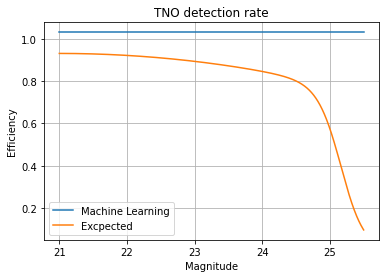

In [12]:
model = None
minScore = None
path = archive.new(name = archive.description(M = subset_multiplier, N = n, K = K, E = epoch))
output = open(f"{path}/ouput.csv","w")

# Loop over generations (genetic algorithm)
for i in range(n):
  
  print(f"🔁 Generation {i+1}/{n}")

  # Shuffling data and creating folds
  np.random.shuffle(data)

  folds = []
  for j in range(K):
    folds.append(data[j::K])

################################################################################
  # Splitting data for training and test...

  x_train = []; y_train = []; x_test = []; y_test = []
  for j, fold in enumerate(folds):
    train_sets = int(len(fold)*train_prop)
    index = np.zeros(len(fold),dtype=bool)
    index[:train_sets] = True
    np.random.shuffle(index)

    data_train = fold[index]
    data_test  = fold[~index]

    x_train.append(data_train[:,:-4])
    y_train.append(data_train[:,-4:])
    x_test.append(data_test [:,:-4])
    y_test.append(data_test [:,-4:])
  
  x_train = np.array(x_train); y_train = np.array(y_train); x_test = np.array(x_test); y_test = np.array(y_test)

  ################################################################################
  # Training K models independently

  models = []; history = []; scores = []
  for j in range(K):
    X = np.concatenate(x_train[np.arange(len(x_train))!=j])
    Y = np.concatenate(y_train[np.arange(len(y_train))!=j])

    if len(models) < j+1: models.append(get_model(X))
    else: models.append(model)

    print(f"🏃‍♀️ Training model  with fold {j} as test...", end="\r")

    history.append(models[j].fit(X, Y, epochs = epoch, verbose = 0))#, validation_data = (x_test[j], y_test[j])))

    scores.append(models[j].evaluate(x_test[j], y_test[j], verbose=0))

  output.write("Generation; ")
  for j in np.arange(len(scores)): output.write(f"Score of model {j};")
  output.write("Score retained\n")

  output.write(f"{i+1}; ")
  if minScore is None: minScore = scores[0][0]
  if model is None: model = models[0]
  for j,s in enumerate(scores):
    output.write(f"{s[0]}; ") 
    if s[0] < minScore:
      minScore = s[0]
      model = models[j]
  output.write(f"{minScore}\n") 

  ################################################################################
  # Making new prediction

  print("🔮 Prediction...")
  
  new_data = Block.all["2015BD"].to_ai_ready(func="square")

  new_x = new_data[:-4]
  new_y = new_data[-4:]
  new_x = (new_x - mean) / std

  new_x=np.array(new_x).reshape(1,len(new_x))

  predictions = model.predict(new_x)
  print(f"Prediction : {predictions[0]}")

  ################################################################################
  # Plotting the result

  plt.subplot(int(np.ceil(np.sqrt(n))),int(np.ceil(np.sqrt(n))),i+1)
  plt.plot(m,ft(m,*predictions[0]), label="Machine Learning")
  plt.plot(m,fs(m,new_y[0],new_y[1],new_y[2],new_y[3]), label="Excpected")
  if i == 0: plt.title("TNO detection rate")
  if i+1>n-np.ceil(np.sqrt(n)):    plt.xlabel("Magnitude")
  if i%np.ceil(np.sqrt(n))==0: plt.ylabel("Efficiency")
  plt.grid()
  if i==0: plt.legend()

################################################################################
# Saving results

output.close()
plt.savefig(f"{path}/tno_efficiency_rate.png")
model.save(f"{path}/model.ckpt")
plt.show()